# Unsupervised Learning (Data Structure, Data Density, & Structure in Random Data)

## TACC Intro to Machine Learning July 2024

### Overview

This Jupyter Notebook accompanies the lecture slides for TACC Intro to Machine Learning July 2024 course. Figures in those slides were created using code in this notebook unless otherwise specified.

### Instructions

Run the code blocks in the order presented and consider the outputs.

Some sections contain questions and additional exercises you can complete.

### Objective

After working through this notebook, you should gain experience in the following areas:

- Simulating data using functions provided in `sklearn` and `numpy`.
- Implementing unsupervised learning methods on simulated and example datasets:
    - Principal Components Analysis
    - K-Means Clustering
    - Agglomerative Hierarchical Clustering
    - Gaussian Mixture Models
    - DBSCAN Clustering
- Summarizing and interpreting the outputs of these unsupervised learning methods.


# Hands-on break \#2

## [Data Structure](#struct)
- ### [K-Means Clustering](#kmeans)
    - ### [Exercise 2](#ex2)
- ### [Clustering Principal Components](#clustpca)
    - ### [Exercise 3](#ex3)
- ### [Cluster Size](#size)
- ### [Cluster Shape](#shape)
- ### [Agglomerative Clustering](#agg)
    - ### [Exercise 4](#ex4)

# Hands-on break \#3

## [Data Density](#dens)
- ### [Gaussian Mixture Models (GMM)](#gmm)
- ### [Influence of Covariance Matrix on GMM](#covmat)
- ### [GMM for Data Generation](#generate)
- ### [DBSCAN](#dbscan)
    - ### [Excercise 5](#ex5)

## [Structure in Random Data](#rand)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
from matplotlib.colors import ListedColormap, colorConverter, LinearSegmentedColormap
mpl.rcParams.update({'font.size': 16})
import sklearn
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons

We can print the versions of each package to confirm we have the expected versions:

In [2]:
np.__version__

'1.24.4'

In [3]:
sklearn.__version__

'1.2.0'

In [4]:
mpl.__version__

'3.8.2'

In [5]:
pd.__version__

'1.5.3'

In [6]:
scipy.__version__

'1.11.4'

## Plotting Utilities <a name="plotting"></a>

We will use this custom function, which is built on Matplotlib, to generate plots for the exercises in this notebook.

In [7]:
def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None,
                     labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None):
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unique_y = np.unique(y)

    if markers is None:
        markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(markers) == 1:
        markers = markers * len(unique_y)

    if labels is None:
        labels = unique_y

    # lines in the matplotlib sense, not actual lines
    lines = []

    current_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unique_y, current_cycler())):
        mask = y == yy
        # if c is none, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # use light edge for dark markers
        if np.mean(colorConverter.to_rgb(color)) < .4:
            markeredgecolor = "grey"
        else:
            markeredgecolor = "black"

        lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
                             label=labels[i], alpha=alpha, c=color,
                             markeredgewidth=markeredgewidth,
                             markeredgecolor=markeredgecolor)[0])

    if padding != 0:
        pad1 = x1.std() * padding
        pad2 = x2.std() * padding
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lines

# Data Structure

## K-Means Clustering <a name="kmeans"></a>

### Simulate Data with Five Clusters

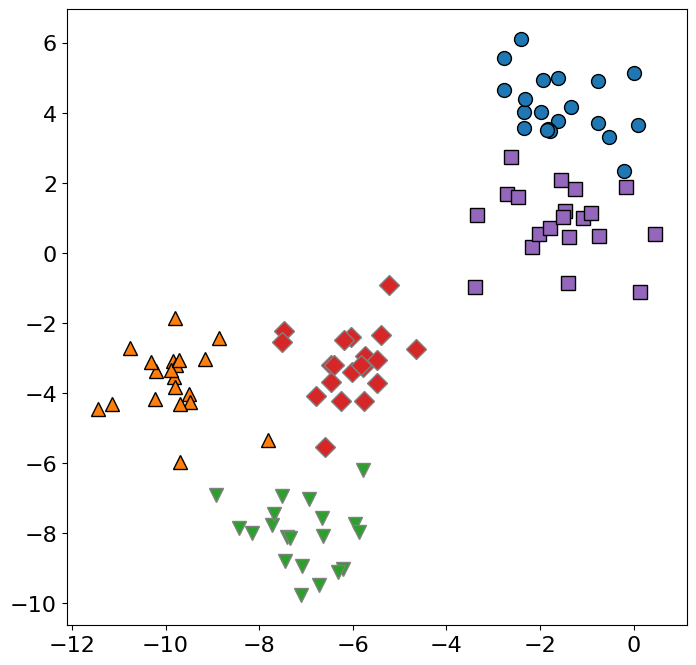

In [22]:
from sklearn.cluster import KMeans

# generate synthetic two-dimensional data with 5 centers
X, y = make_blobs(centers=5, random_state=1)

plt.figure(figsize=(8,8))
discrete_scatter(X[:,0], X[:,1], y)

### Identify Cluster Membership in Simulated Data

We know there are three clusters. Will k-means correctly identify which points belong in which clusters if we identify them?

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 1.0, 'K=7')

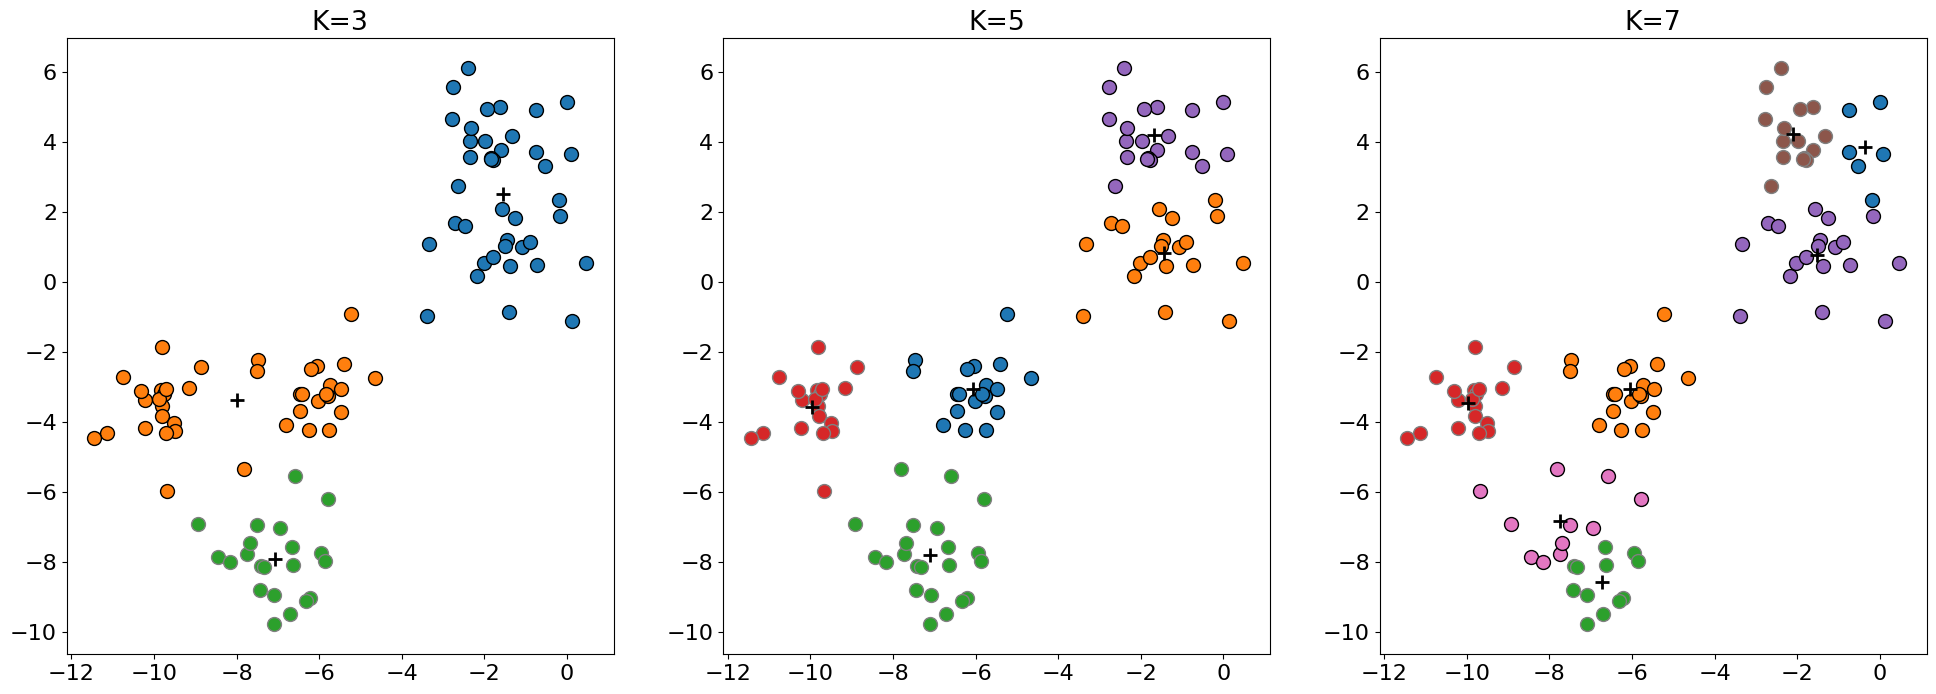

In [23]:
# build the clustering model for different values of k
kmeans_3 = KMeans(n_clusters=3)
kmeans_3.fit(X)

kmeans_5 = KMeans(n_clusters=5)
kmeans_5.fit(X)

kmeans_7 = KMeans(n_clusters=7)
kmeans_7.fit(X)

fig, ax = plt.subplots(1, 3, figsize=(24, 8))
discrete_scatter(X[:, 0], X[:, 1], kmeans_3.labels_, markers='o', ax=ax[0])
discrete_scatter(
    kmeans_3.cluster_centers_[:, 0], kmeans_3.cluster_centers_[:, 1], 
    markers='+', markeredgewidth=2, ax=ax[0]
)
ax[0].set_title('K=3')

discrete_scatter(X[:, 0], X[:, 1], kmeans_5.labels_, markers='o', ax=ax[1])
discrete_scatter(
    kmeans_5.cluster_centers_[:, 0], kmeans_5.cluster_centers_[:, 1], 
    markers='+', markeredgewidth=2, ax=ax[1]
)
ax[1].set_title('K=5')

discrete_scatter(X[:, 0], X[:, 1], kmeans_7.labels_, markers='o', ax=ax[2])
discrete_scatter(
    kmeans_7.cluster_centers_[:, 0], kmeans_7.cluster_centers_[:, 1], 
    markers='+', markeredgewidth=2, ax=ax[2]
)
ax[2].set_title('K=7')

### Selecting the best number of clusters

One approach to selecting the appropriate number of clusters is to try to minimize the mean squared error within each cluster as measured by the euclidean distance from data points to the cluster centroid.

We know there are three clusters in our simulated data, but the mean squared error always decreases as we increase the number of clusters K that we consider. Error will be zero when each point is in its own cluster, but this would be greatly overfitting the data and would not be helpful.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Text(0, 0.5, 'Mean Squared Error')

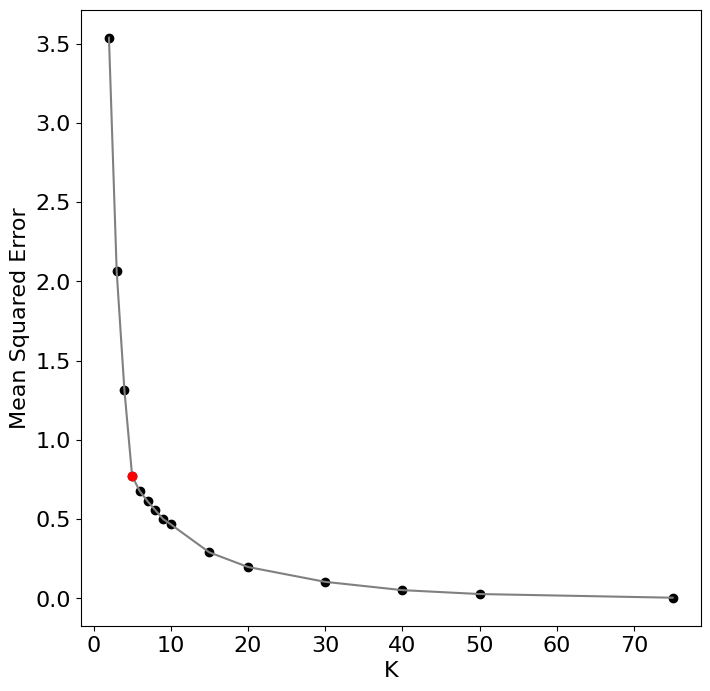

In [24]:
from sklearn.metrics import mean_squared_error

k_val = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50, 75]

mse = []
for k in k_val:
# build the clustering model
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    centers = [kmeans.cluster_centers_[i] for i in kmeans.labels_]
    mse.append(mean_squared_error(X, centers))

plt.figure(figsize=(8,8))
plt.plot(k_val, mse, color='gray')
plt.scatter(k_val, mse, marker='o', color='k')
plt.plot(5, mse[3], marker='o', color='r')
plt.xlabel('K')
plt.ylabel('Mean Squared Error')

One alternative method for selecting the number of clusters is the Bayesian Information Criterion. This method incorporates a penalty for increasing the number of clusters K to avoid overfitting.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Text(0, 0.5, 'BIC')

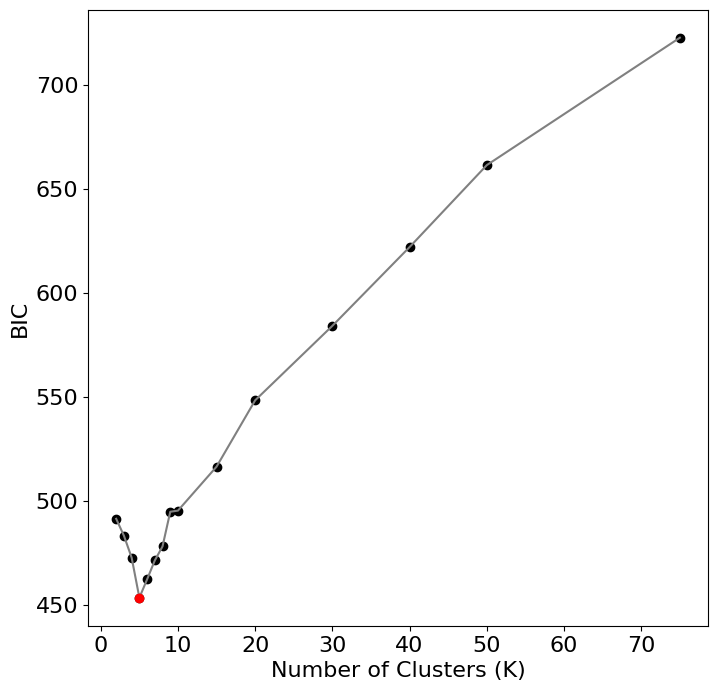

In [25]:
# modified from https://stats.stackexchange.com/questions/90769/using-bic-to-estimate-the-number-of-k-in-kmeans

from scipy.spatial import distance

def bic_kmeans(kmeans, X):
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape
    const_term = 0.5 * m * np.log(N) * (d+1)
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)], [centers[0][i]], 'euclidean')**2) for i in range(m)])
    bic = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term
    
    return bic

k_val = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50, 75]

bic = []
for k in k_val:
# build the clustering model
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    # the BIC from the function has an inverse sign from the regular definition
    bic.append(-bic_kmeans(kmeans, X))

plt.figure(figsize=(8,8))
plt.plot(k_val, bic, color='gray')
plt.scatter(k_val, bic, marker='o', color='k')
plt.plot(5, bic[3], marker='o', color='r')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('BIC')

### Hands On Activity \#2 <a name="ex2"></a>

Simulate new datasets with 3, 8, and 15 clusters. How do the plots of K vs MSE and K vs BIC change?

## Clustering Principal Components <a name="clustpca"></a>

Returning to the breast tumor data set, we can use the first and second principal components in K-Means clustering.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0, 0.5, 'Second principal component')

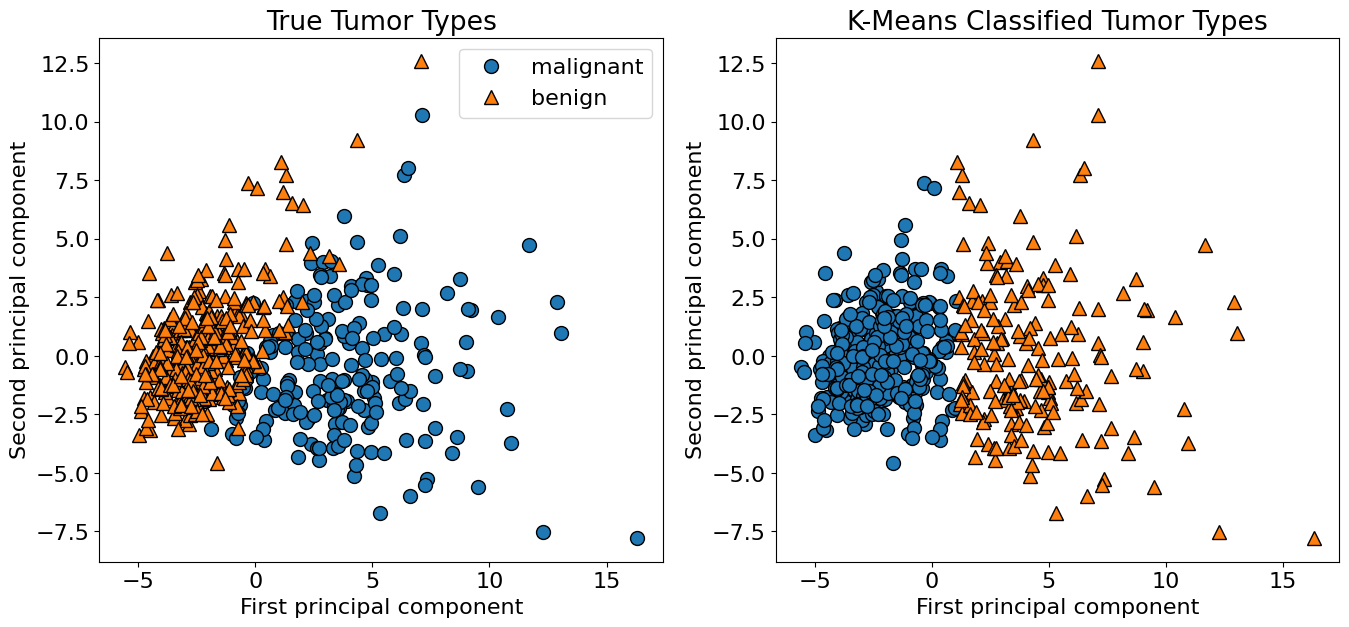

In [26]:
from sklearn.decomposition import PCA
cancer = load_breast_cancer()

scaler = StandardScaler()
scaler.fit(cancer.data) # standardize each feature to same scale
X_scaled = scaler.transform(cancer.data)

pca = PCA(n_components=2)
pca.fit(X_scaled)
# fit PCA model to beast cancer data
# transform data onto the first two principal components
X_pca = pca.transform(X_scaled)

kmeans_bt = KMeans(n_clusters=2)
kmeans_bt.fit(X_pca)

fig, ax = plt.subplots(1, 2, figsize=(16,8))

discrete_scatter(x1=X_pca[:, 0], x2=X_pca[:, 1], y=cancer.target, ax=ax[0])
ax[0].set_title('True Tumor Types')
ax[0].legend(cancer.target_names, loc="best")
ax[0].set_aspect("equal")
ax[0].set_xlabel("First principal component")
ax[0].set_ylabel("Second principal component")

discrete_scatter(x1=X_pca[:,0], x2=X_pca[:,1], y=kmeans_bt.labels_, ax=ax[1])
ax[1].set_title('K-Means Classified Tumor Types')
ax[1].set_aspect("equal")
ax[1].set_xlabel("First principal component")
ax[1].set_ylabel("Second principal component")

### Hands On Activity \#3 <a name="ex3"></a>

Load the setosa data set and reduce its dimensionality with PCA. Then perform clustering using the first two principal components.
- How many clusters are best supported by BIC? By MSE?
- Do those clusters correctly classify the species?

## Cluster Size <a name="size"></a>

In [27]:
# generate synthetic two-dimensional data with 3 centers and uneven sample sizes
X_unequal, y_unequal = make_blobs(n_samples=[5, 80, 15], centers=[[-4, 0], [0, 0], [4, 0]], random_state=1)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 1.0, 'Inferred Clusters, K=3')

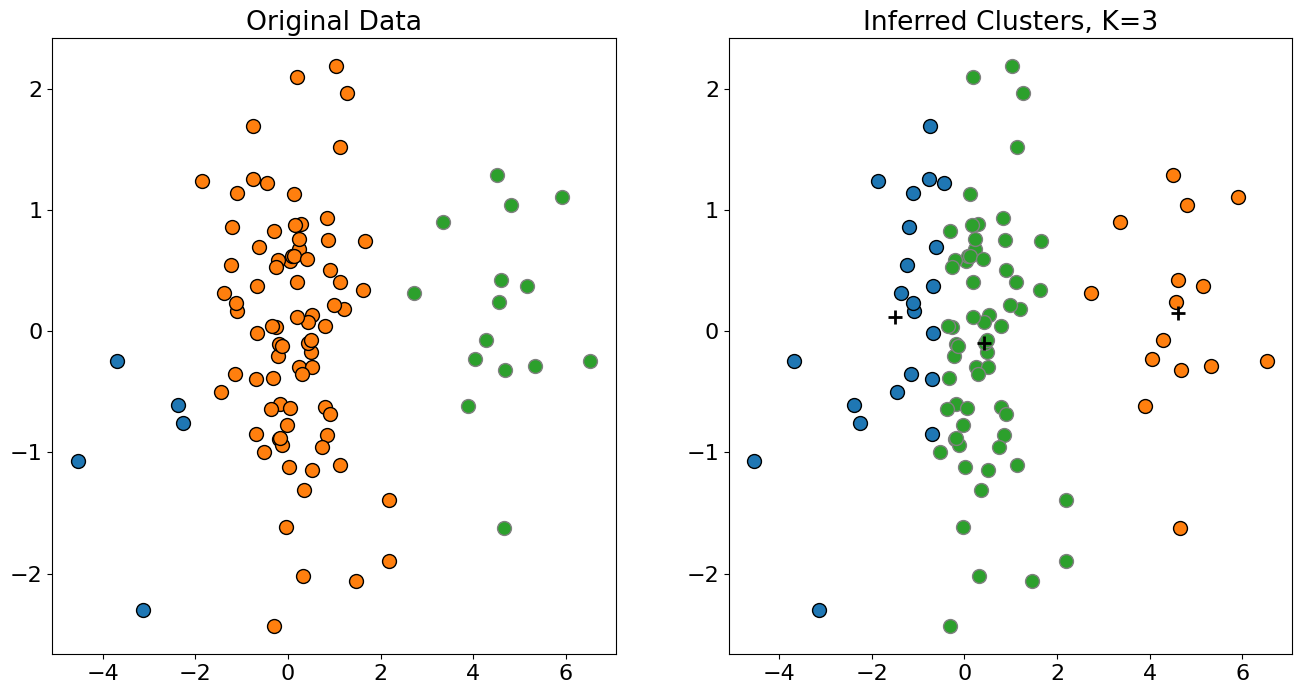

In [28]:
# build the clustering model 
kmeans_unequal = KMeans(n_clusters=3)
kmeans_unequal.fit(X_unequal)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
discrete_scatter(X_unequal[:,0], X_unequal[:,1], y_unequal, markers='o', ax=ax[0])
ax[0].set_title('Original Data')
discrete_scatter(X_unequal[:, 0], X_unequal[:, 1], kmeans_unequal.labels_, markers='o', ax=ax[1])
discrete_scatter(
    kmeans_unequal.cluster_centers_[:, 0], kmeans_unequal.cluster_centers_[:, 1], 
    markers='+', markeredgewidth=2, ax=ax[1]
)
ax[1].set_title('Inferred Clusters, K=3')

## Cluster Shape <a name="shape"></a>

K-Means assumes spherical Gaussian clusters. The next section shows how K-Means fails when this assumption is violated.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 1.0, 'Inferred Clusters, K=2')

<Figure size 1000x1000 with 0 Axes>

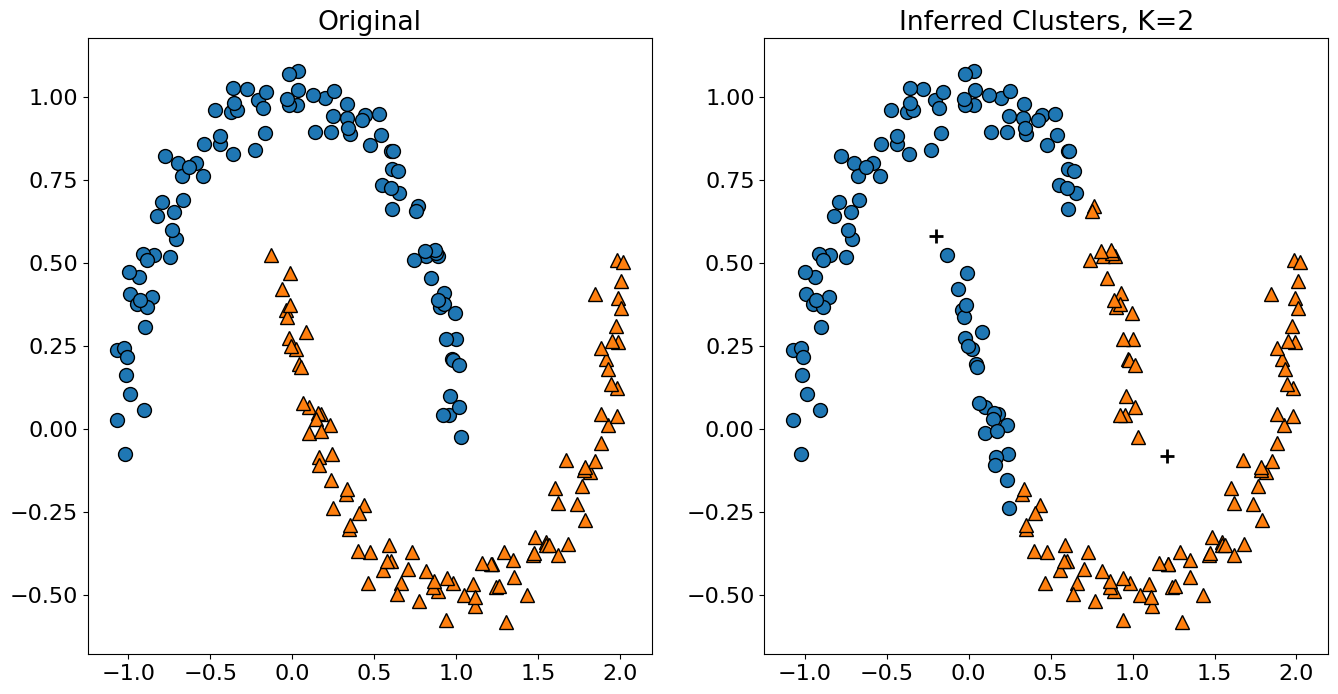

In [29]:
# A hard case
# generate synthetic two_moons data 

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# cluster the data into two clusters
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
y_pred = kmeans.predict(X)
plt.figure(figsize=(10, 10))

fig, ax = plt.subplots(1, 2, figsize=(16,8))
# plot the cluster assignments and cluster centers
discrete_scatter(X[:, 0], X[:, 1], y, ax=ax[0])
ax[0].set_title('Original')
discrete_scatter(X[:, 0], X[:, 1], y_pred, ax=ax[1])
discrete_scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    markers='+', markeredgewidth=2, ax=ax[1]
)
ax[1].set_title('Inferred Clusters, K=2')

## Agglomerative Clustering <a name="agg"></a>

### MIN (Single Link) Clustering

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [10.0, 10.0, 32.5, 32.5]],
 'dcoord': [[0.0, 1.3928388277184127, 1.3928388277184127, 0.0],
  [0.0, 2.0223748416156684, 2.0223748416156684, 0.0],
  [0.0, 7.057619995437555, 7.057619995437555, 2.0223748416156684],
  [1.3928388277184127,
   7.955501241279521,
   7.955501241279521,
   7.057619995437555]],
 'ivl': ['3', '4', '2', '0', '1'],
 'leaves': [3, 4, 2, 0, 1],
 'color_list': ['C1', 'C2', 'C0', 'C0'],
 'leaves_color_list': ['C1', 'C1', 'C0', 'C2', 'C2']}

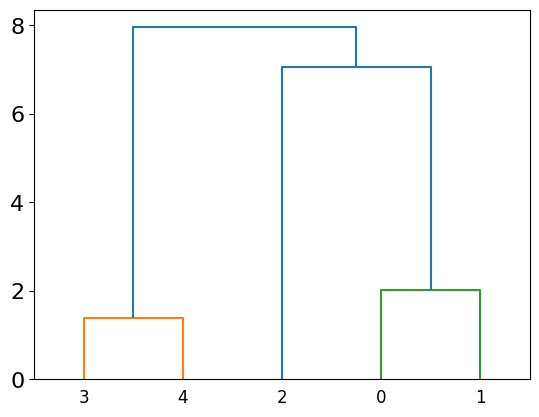

In [30]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage

X = [
    [1, 2],
    [1.3, 4],
    [0.1, -5],
    [8.7, 0],
    [10, -0.5]
]

dist_mat = pdist(X)
# reformat the linkage matrix for use in dendrogram function and plot dendrogram
linkage_matrix = linkage(dist_mat, "single")
dendrogram(linkage_matrix, distance_sort="ascending")

In [31]:
# pretty formatting
dist_square = squareform([round(i, 1) for i in dist_mat])
print(pd.DataFrame(dist_square))

     0    1     2    3     4
0  0.0  2.0   7.1  8.0   9.3
1  2.0  0.0   9.1  8.4   9.8
2  7.1  9.1   0.0  9.9  10.9
3  8.0  8.4   9.9  0.0   1.4
4  9.3  9.8  10.9  1.4   0.0


### MAX (Complete Linkage) Clustering

We will use the same condensed distance matrix as above.

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [10.0, 10.0, 32.5, 32.5]],
 'dcoord': [[0.0, 1.3928388277184127, 1.3928388277184127, 0.0],
  [0.0, 2.0223748416156684, 2.0223748416156684, 0.0],
  [0.0, 9.079647570252934, 9.079647570252934, 2.0223748416156684],
  [1.3928388277184127,
   10.874741376235114,
   10.874741376235114,
   9.079647570252934]],
 'ivl': ['3', '4', '2', '0', '1'],
 'leaves': [3, 4, 2, 0, 1],
 'color_list': ['C1', 'C2', 'C0', 'C0'],
 'leaves_color_list': ['C1', 'C1', 'C0', 'C2', 'C2']}

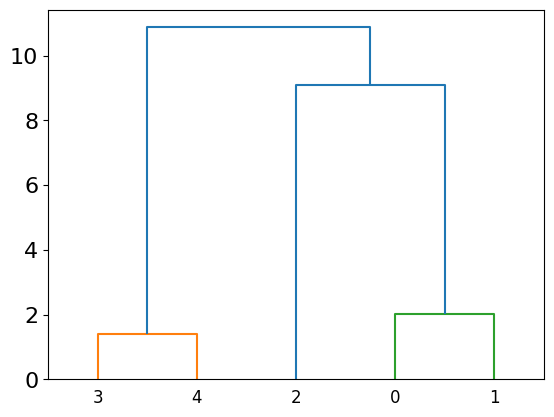

In [32]:
linkage_matrix_complete = linkage(dist_mat, "complete")
dendrogram(linkage_matrix_complete)

### Group Average Clustering

Again, using the same linkage matrix.

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [10.0, 10.0, 32.5, 32.5]],
 'dcoord': [[0.0, 1.3928388277184127, 1.3928388277184127, 0.0],
  [0.0, 2.0223748416156684, 2.0223748416156684, 0.0],
  [0.0, 8.068633782845245, 8.068633782845245, 2.0223748416156684],
  [1.3928388277184127,
   9.387611754053331,
   9.387611754053331,
   8.068633782845245]],
 'ivl': ['3', '4', '2', '0', '1'],
 'leaves': [3, 4, 2, 0, 1],
 'color_list': ['C1', 'C2', 'C0', 'C0'],
 'leaves_color_list': ['C1', 'C1', 'C0', 'C2', 'C2']}

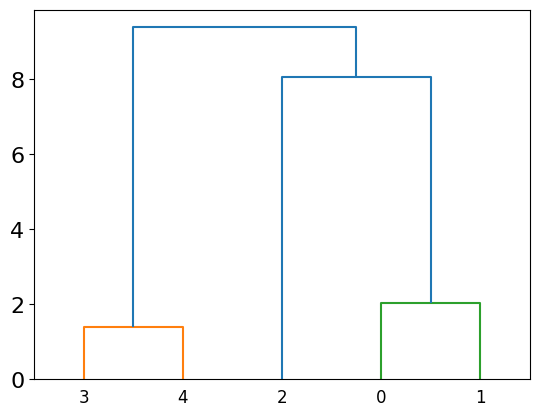

In [33]:
linkage_matrix_average = linkage(dist_mat, "average")
dendrogram(linkage_matrix_average)

### Ward's Method Clustering

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [10.0, 10.0, 32.5, 32.5]],
 'dcoord': [[0.0, 1.3928388277184127, 1.3928388277184127, 0.0],
  [0.0, 2.0223748416156684, 2.0223748416156684, 0.0],
  [0.0, 9.31683064852707, 9.31683064852707, 2.0223748416156684],
  [1.3928388277184127,
   13.276395093046403,
   13.276395093046403,
   9.31683064852707]],
 'ivl': ['3', '4', '2', '0', '1'],
 'leaves': [3, 4, 2, 0, 1],
 'color_list': ['C1', 'C2', 'C0', 'C0'],
 'leaves_color_list': ['C1', 'C1', 'C0', 'C2', 'C2']}

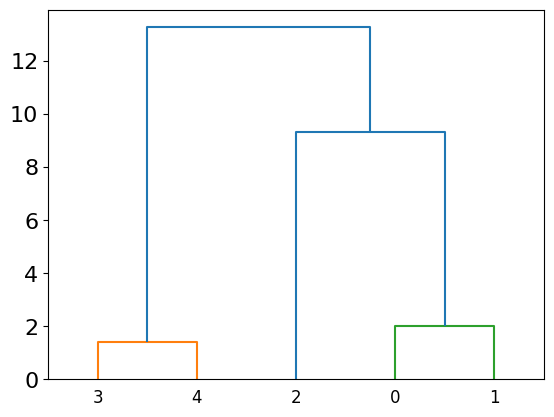

In [34]:
linkage_matrix_ward = linkage(dist_mat, "ward")
dendrogram(linkage_matrix_ward)

### Hands On Activity \#4 <a name="ex4"></a>

Simulate two-dimensional data with 10, 20 and 100 observations using the `make_blobs()` function, then perform MIN clustering.


## Gaussian Mixture Models (GMM) <a name="gmm"></a>

Some code from https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

### Simulate data and fit GMM

Text(0.5, 1.0, 'GMM Clustered Data, 4 components')

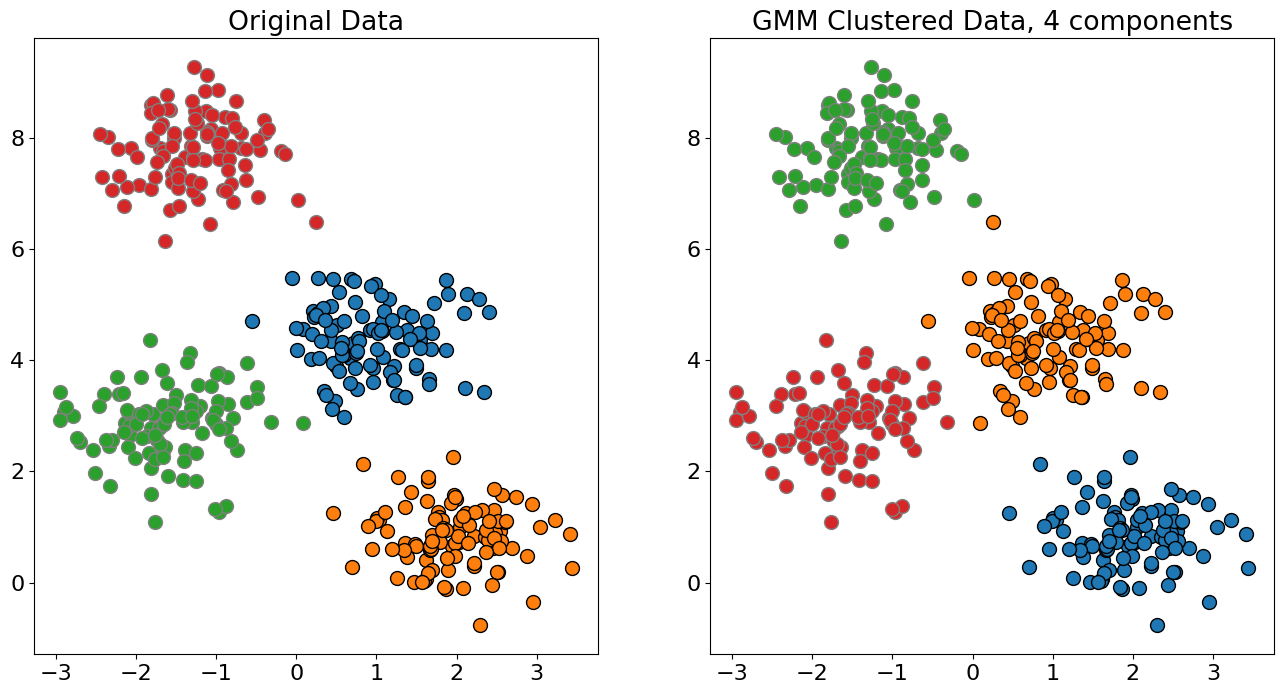

In [35]:
from sklearn.mixture import GaussianMixture as GMM
X, y = make_blobs(n_samples=400, centers=4,
                  cluster_std=0.60, random_state=0)

gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)
fig, ax = plt.subplots(1, 2, figsize=(16,8))
discrete_scatter(X[:, 0], X[:, 1], y=y, markers='o', ax=ax[0])
ax[0].set_title('Original Data')
discrete_scatter(X[:, 0], X[:, 1], y=labels, markers='o', ax=ax[1])
ax[1].set_title('GMM Clustered Data, 4 components')

{'alpha': 0.2}
{'alpha': 0.19614271588306442}
{'alpha': 0.1954743332407301}
{'alpha': 0.19409140479603385}


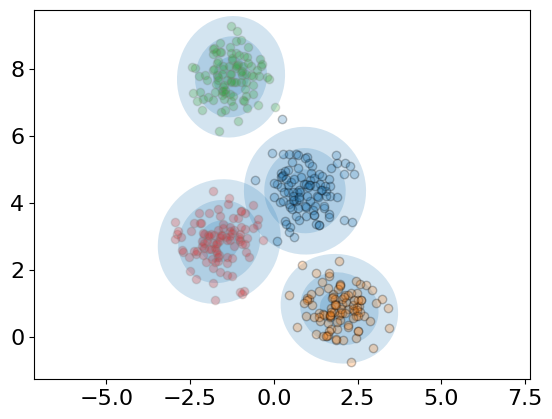

In [36]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    elif covariance.shape == ():
        angle = 0
        width = height = 2 * np.sqrt(covariance)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    print(kwargs)
    # Draw the Ellipse
    for nsig in range(1, 4):
        Ellipse(xy=position, width=nsig * width, height=nsig * height, angle=angle, **kwargs)
        ax.add_patch(Ellipse(xy=position, width=nsig * width, height=nsig * height,
                            angle=angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        discrete_scatter(X[:, 0], X[:, 1], y=labels, s=6, markers='o', ax=ax, alpha=0.25)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=1, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor, ax=ax)
        
gmm = GMM(n_components=4, random_state=42)
plot_gmm(gmm, X)


### Compare GMM to K-Means Clustering

In [37]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    discrete_scatter(X[:, 0], X[:, 1], y=labels, s=6, markers='o', ax=ax, alpha=0.25)
    
    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))    
        
kmeans = KMeans(n_clusters=4, random_state=0)

{'alpha': 0.2}
{'alpha': 0.19614271588306442}
{'alpha': 0.1954743332407301}
{'alpha': 0.19409140479603385}


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 1.0, 'K-Means Fits Circles Around Clusters')

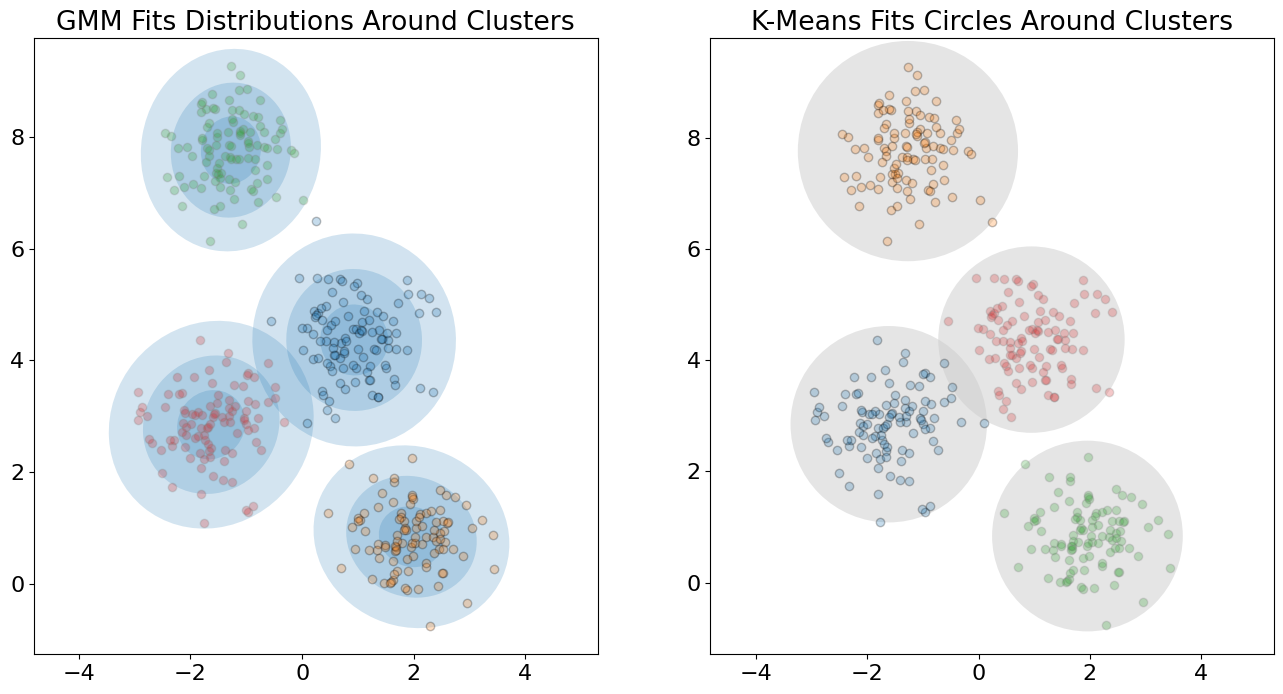

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
plot_gmm(gmm, X, ax=ax[0])
ax[0].set_title('GMM Fits Distributions Around Clusters')
plot_kmeans(kmeans, X, ax=ax[1])
ax[1].set_title('K-Means Fits Circles Around Clusters')

## Influence of Covariance Matrix on GMM <a name="covmat"></a>

{'alpha': 0.2}
{'alpha': 0.2}
{'alpha': 0.2}


Text(0.5, 1.0, 'Full Covariance Matrix')

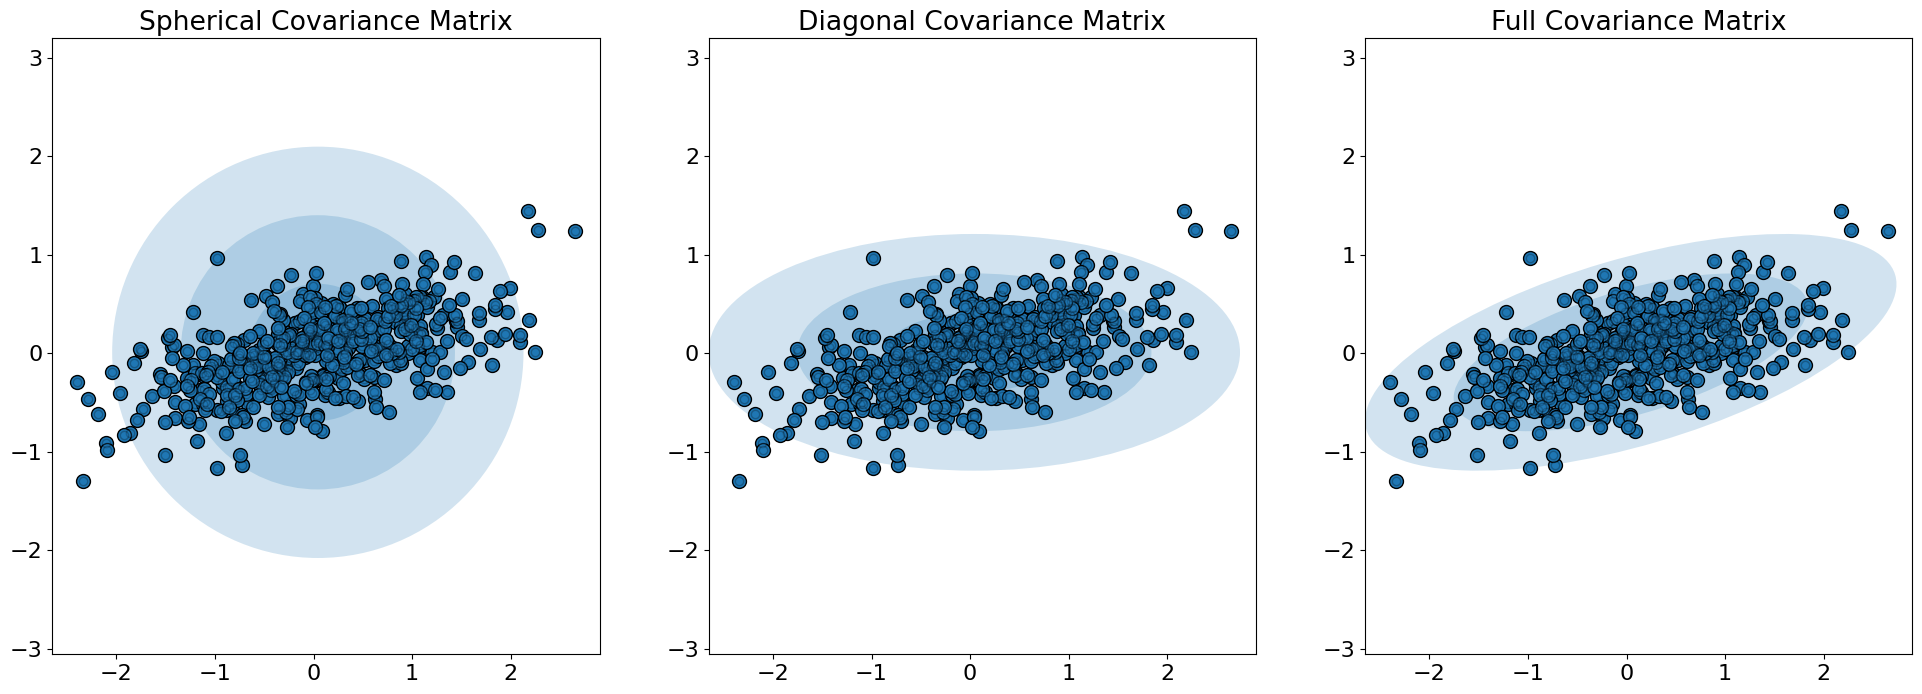

In [39]:
from sklearn.mixture import GaussianMixture as GMM

rng = np.random.RandomState(5)
X = np.dot(rng.randn(500, 2), rng.randn(2, 2))

gmm_sphere = GMM(n_components=1, covariance_type='spherical')

gmm_diag = GMM(n_components=1, covariance_type='diag')

gmm_full = GMM(n_components=1, covariance_type='full')

fig, ax = plt.subplots(1, 3, figsize=(24, 8))

discrete_scatter(X[:, 0], X[:, 1], ax=ax[0])
plot_gmm(gmm_sphere, X, ax=ax[0])
ax[0].set_title('Spherical Covariance Matrix')

discrete_scatter(X[:, 0], X[:, 1], ax=ax[1])
plot_gmm(gmm_diag, X, ax=ax[1])
ax[1].set_title('Diagonal Covariance Matrix')

discrete_scatter(X[:, 0], X[:, 1], ax=ax[2])
plot_gmm(gmm_full, X, ax=ax[2])
ax[2].set_title('Full Covariance Matrix')

## GMM for Data Generation <a name="generate"></a>

You can use GMM to define a Gaussian mixture distribution from which to draw data.

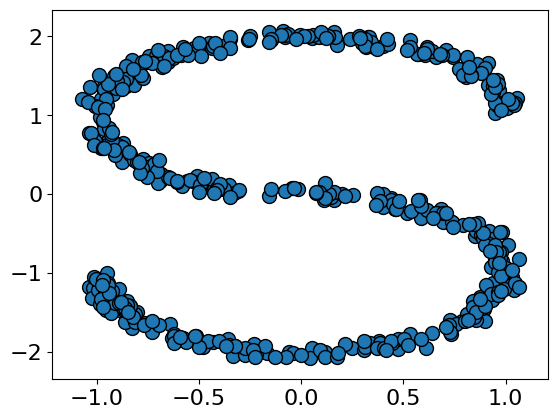

In [40]:
from sklearn.datasets import make_s_curve
X, y = make_s_curve(n_samples=500, noise=0.05, random_state=0)
X = np.delete(X, 1, axis=1) # delete unnecessary dimension of data
discrete_scatter(X[:, 0], X[:, 1])

{'alpha': 0.2}
{'alpha': 0.13621471032872323}
{'alpha': 0.16570959797695747}
{'alpha': 0.09377962332578466}
{'alpha': 0.19999999999999998}
{'alpha': 0.11830083835758635}
{'alpha': 0.15665702978848614}
{'alpha': 0.11292839288710688}
{'alpha': 0.16595874709869798}
{'alpha': 0.15311481696288823}
{'alpha': 0.1986850723591206}
{'alpha': 0.2}
{'alpha': 0.117241457899059}
{'alpha': 0.16888908848816492}
{'alpha': 0.12253901094254546}
{'alpha': 0.10009833682717145}


Text(0.5, 1.0, '10 Components')

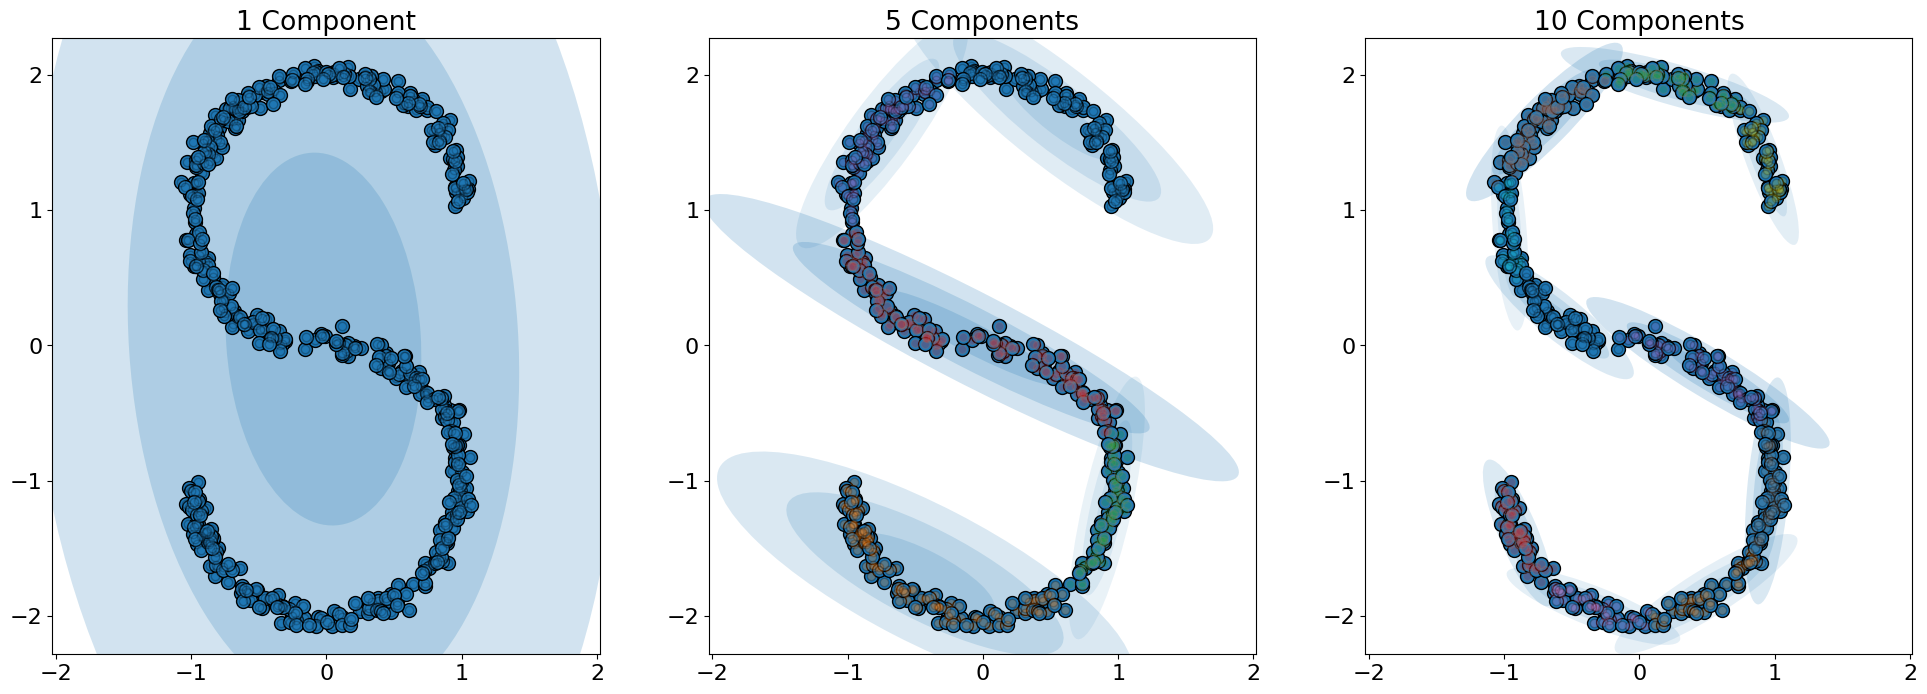

In [41]:
gmm_1 = GMM(n_components=1).fit(X)
gmm_5 = GMM(n_components=5).fit(X)
gmm_10 = GMM(n_components=10).fit(X)

fig, ax = plt.subplots(1, 3, figsize=(24, 8))

discrete_scatter(X[:, 0], X[:, 1], ax=ax[0])
plot_gmm(gmm_1, X, ax=ax[0])
ax[0].set_title('1 Component')

discrete_scatter(X[:, 0], X[:, 1], ax=ax[1])
plot_gmm(gmm_5, X, ax=ax[1])
ax[1].set_title('5 Components')

discrete_scatter(X[:, 0], X[:, 1], ax=ax[2])
plot_gmm(gmm_10, X, ax=ax[2])
ax[2].set_title('10 Components')

The `sample()` function will sample across all the components fitted by the GMM.

In [42]:
sample_10 = gmm_10.sample(n_samples=500)

(-2.0, 2.0)

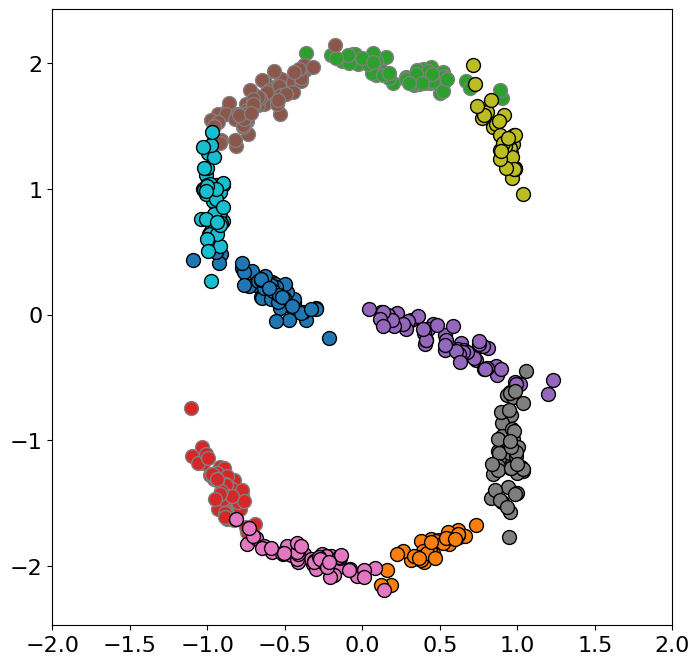

In [43]:
plt.figure(figsize=(8,8))
discrete_scatter(sample_10[0][:, 0], sample_10[0][:, 1], sample_10[1], markers='o')
plt.xlim(-2, 2)

## DBSCAN <a name="dbscan"></a>

In [44]:
from copy import deepcopy
X1, y = make_moons(n_samples=200, noise=0.1, random_state=0)

# make a more complicated shape by shifting moons and adding to original data
X2 = deepcopy(X1)
X2[:, 0] += 2
X = np.vstack([X1, X2])
y = np.concatenate((y, y))

In [45]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.2, min_samples=2).fit(X)

Text(0.5, 1.0, 'DBSCAN Result')

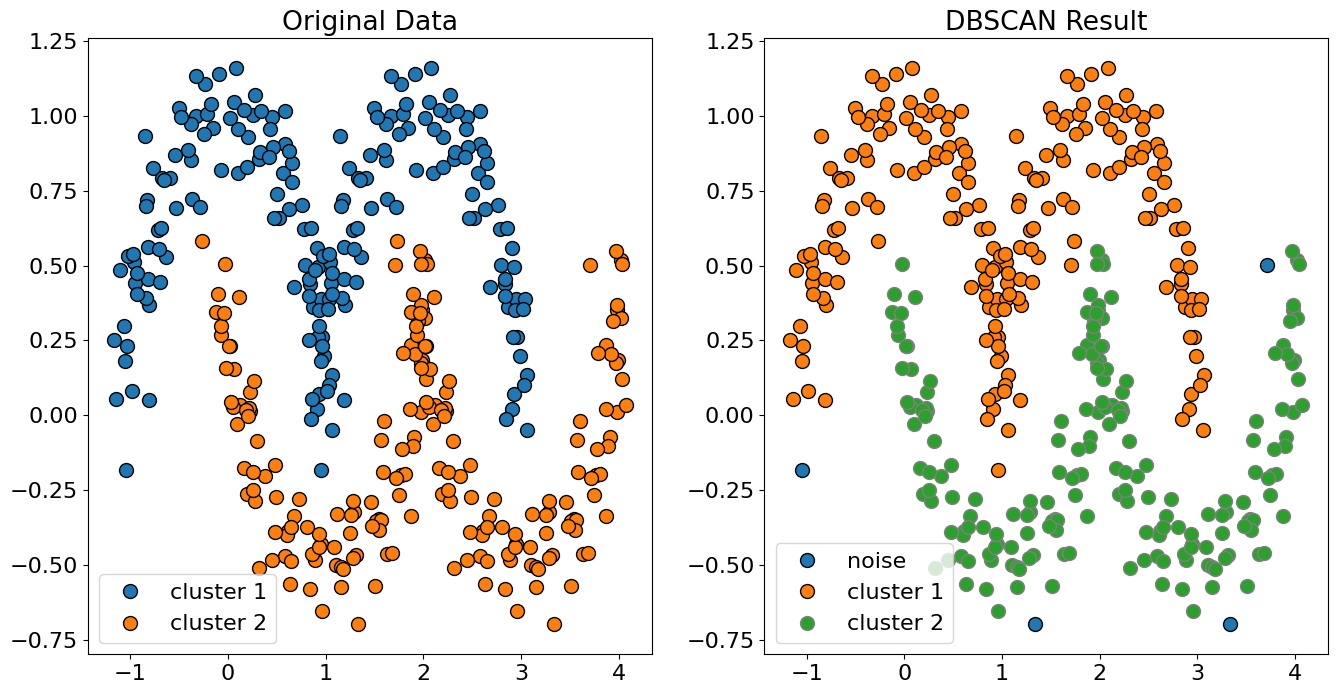

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
discrete_scatter(X[:, 0], X[:, 1], y, ax=ax[0], markers='o')
ax[0].set_title('Original Data')
ax[0].legend(labels=['cluster 1', 'cluster 2'])
discrete_scatter(X[:, 0], X[:, 1], clustering.labels_, ax=ax[1], markers='o')
ax[1].legend(labels=['noise', 'cluster 1', 'cluster 2'])
ax[1].set_title('DBSCAN Result')

### Hands On Activity \#5 <a name="ex5"></a>

1. Explore how changing parameters `eps` and `min_samples` influences the DBSCAN fit.
2. Explore how increasing or decreasing the noise in the data simulation changes the performance of the algorithm.
3. Try to simulate more complicated shapes to see how the DBSCAN algorithm performs.

# Structure in Random Data <a name="rand"></a>

This tutorial shows how unsupervised learning can help you understand data representation, structure and density.

We make heavy use of data simulation to demonstrate the performance of these tools, and when we simulate data we have a known truth. We know in advance how many clusters we expect, or whether there are meaningful axes of variation in our example data.

With real, novel data you will not know in advance the answer you expect, though you may have patterns you hope to find. It is possible, however, to find patterns where none exist.

The final section of this notebook simulates noise across a uniform distribution to show how some algorithms will find patterns when none exist.

In [47]:
from numpy.random import uniform, seed

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 1.0, 'DBSCAN, eps=0.4, minPts=2')

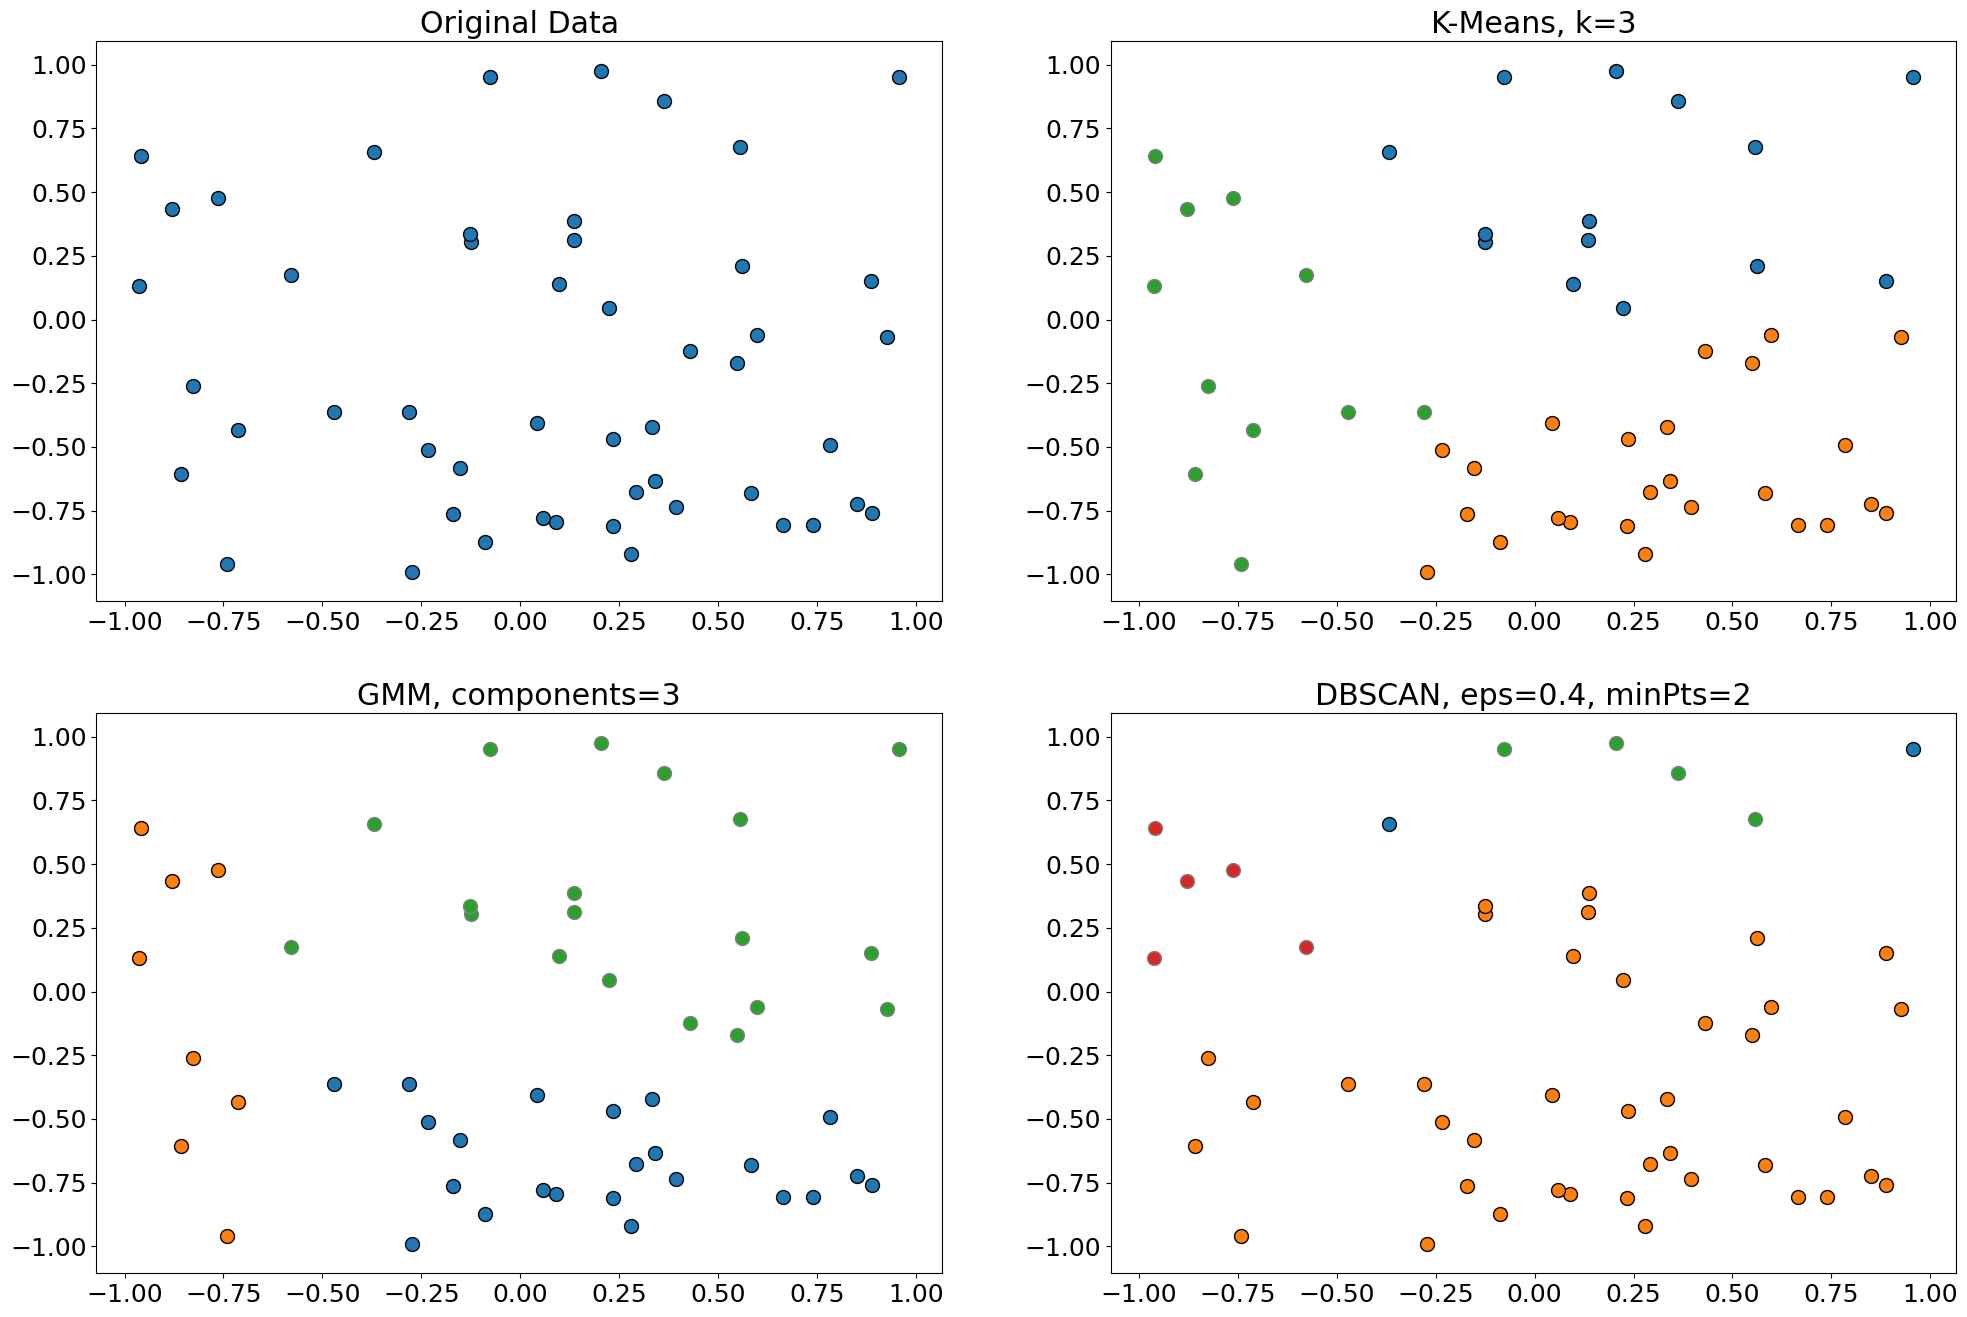

In [48]:
seed(0)
x1 = uniform(-1, 1, 50)
x2 = uniform(-1, 1, 50)
y = [0 for i in range(50)] # all one "cluster"
X = np.array([[x1[i], x2[i]] for i in range(50)])

# k-means
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

# GMM
gmm = GMM(n_components=3, random_state=0)
labels = gmm.fit(X).predict(X)

# DBSCAN
dbscan = DBSCAN(eps=0.4, min_samples=2).fit(X)

# plots
mpl.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(2, 2, figsize=(24,16))
discrete_scatter(X[:,0], X[:, 1], markers='o', ax=ax[0,0])
ax[0,0].set_title('Original Data')

discrete_scatter(X[:, 0], X[:, 1], kmeans.labels_, markers='o', ax=ax[0,1])
ax[0,1].set_title('K-Means, k=3')

discrete_scatter(X[:, 0], X[:, 1], labels, markers='o', ax=ax[1,0])
ax[1,0].set_title('GMM, components=3')

discrete_scatter(X[:, 0], X[:, 1], dbscan.labels_, markers='o', ax=ax[1,1])
ax[1,1].set_title('DBSCAN, eps=0.4, minPts=2')